# Import Libraries and Data

In [ ]:
# ## This cell is exclusively for checking to see if you are using your GPU as TF's hardware accelerator

# %tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
## If using Google Colab, use this code to upload data file to Google Collab from the local drive

from google.colab import files
uploaded = files.upload()
btc = files.upload()

Saving eth.csv to eth.csv


Saving btc.csv to btc.csv


In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.templates.default = 'plotly_dark'

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('eth.csv')
df2 = pd.read_csv('btc.csv')

print(df.shape)
display(df)

print(df2.shape)
display(df)

(2134, 7)


,Date,Open_,High,Low,Close__,Volume,MarketCap
0,"Jun 08, 2021","$2,594.60","$2,620.85","$2,315.55","$2,517.44","$41,909,736,778","$292,557,075,207"
1,"Jun 07, 2021","$2,713.05","$2,845.19","$2,584.00","$2,590.26","$30,600,111,277","$300,985,400,826"
2,"Jun 06, 2021","$2,629.75","$2,743.44","$2,616.16","$2,715.09","$25,311,639,414","$315,453,931,558"
3,"Jun 05, 2021","$2,691.62","$2,817.48","$2,558.23","$2,630.58","$30,496,672,724","$305,598,725,249"
4,"Jun 04, 2021","$2,857.17","$2,857.17","$2,562.64","$2,688.19","$34,173,841,611","$312,256,566,095"
...,...,...,...,...,...,...,...
2129,"Aug 10, 2015",$0.71,$0.73,$0.64,$0.71,"$405,283","$42,818,364"
2130,"Aug 09, 2015",$0.71,$0.88,$0.63,$0.7,"$532,170","$42,399,574"
2131,"Aug 08, 2015",$2.79,$2.80,$0.71,$0.75,"$674,188","$45,486,894"
2132,"Aug 07, 2015",$2.83,$3.54,$2.52,$2.77,"$164,329","$166,610,555"


(2978, 7)


,Date,Open_,High,Low,Close__,Volume,MarketCap
0,"Jun 08, 2021","$2,594.60","$2,620.85","$2,315.55","$2,517.44","$41,909,736,778","$292,557,075,207"
1,"Jun 07, 2021","$2,713.05","$2,845.19","$2,584.00","$2,590.26","$30,600,111,277","$300,985,400,826"
2,"Jun 06, 2021","$2,629.75","$2,743.44","$2,616.16","$2,715.09","$25,311,639,414","$315,453,931,558"
3,"Jun 05, 2021","$2,691.62","$2,817.48","$2,558.23","$2,630.58","$30,496,672,724","$305,598,725,249"
4,"Jun 04, 2021","$2,857.17","$2,857.17","$2,562.64","$2,688.19","$34,173,841,611","$312,256,566,095"
...,...,...,...,...,...,...,...
2129,"Aug 10, 2015",$0.71,$0.73,$0.64,$0.71,"$405,283","$42,818,364"
2130,"Aug 09, 2015",$0.71,$0.88,$0.63,$0.7,"$532,170","$42,399,574"
2131,"Aug 08, 2015",$2.79,$2.80,$0.71,$0.75,"$674,188","$45,486,894"
2132,"Aug 07, 2015",$2.83,$3.54,$2.52,$2.77,"$164,329","$166,610,555"


# Business Understanding
- Ethereum is a decentralized, open-source blockchain with smart contract functionality. Its adoption in the financial world has grown exponentially over the past few years, and as a result, its price has skyrocketed from being worth less than \$1 to over $2000 at the time of writing this page.
- Due to the uncertainty of decentralized finance, or DeFi, the value of Ethereum is highly volatile, which makes the use of traditional forecasting models such as ARIMA difficult


# Goal/Audience and Data Description

## Goal and Audience

- The goal of this project is to create a model that attempts to accurately predict if the value of Ethereum will go up or down for the next day. If the model predicts a rise, then one unit of Ethereum will be bought. If it predicts a fall, then one unit of Ethereum will be sold.

- The target audience of this project is an investment firm or a retail trader with extensive disposable income.
    - To consistently buy and sell one unit of Ethereum requires a large amount of liquidity, something that most retail investors do not have, hence the specification towards investment firms and the retail investors that fall in the highest percentiles of disposable income/liquidity.

At the end of this project, an evaluation/comparison will be made between the total profit of three different trading strategies by backtesting over the time period of the created test-set:
1. A strategy derived from the best-performing model construcred
2. A Simple Moving Average Model
3. The Buy-and-Hold Strategy

## Data Source

This data was scraped from CoinMarketCap.com using the webscraper Octoparse. The webpages used ajax syntax for the "load page" button, and therfore ajax timeout time needed to be applied in order to properly extract the data. This data is only concerned with Ethereum, and no other coin or blockchain.

## Features

The data includes the following features:

1. Open
2. High
3. Low
4. Close 
5. Volume
6. Market Cap
<br>

This dataset provides a timeline of Ethereum prices and related data from August 7th, 2015 to June 8th, 2021.
<br>


# Data Preprocessing

## Eth Data

In [ ]:
# Convert the 'Date' column to a datetime datatype and set it as the index, then sort the index
df['Date'] = pd.to_datetime(df.Date)
df.set_index(df.Date, inplace=True)
df.drop(df.tail(1).index, inplace=True)
df = df.sort_index()

# Drop the Date column
df = df.drop(columns=['Date'], axis=1)

# Specify columns
cols = list(df.columns)

# Replace the dollar signs and commas with empty character
df[cols] = df[cols].replace({'\$': '', ',': ''}, regex=True)

## Convert all entries to numerical data type
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Rename the columns with unconventinal text in the string
df.rename(columns={'Open_':'Open', 'Close__':'Close'}, inplace=True)

# Find missing values
print(df.isna().sum())

# There are very few missing values, so we will drop all of them
df = df.dropna()

# Check for duplicates in index
print(df.index.duplicated().sum())

# Check for duplicates in columns
print(df.duplicated().sum())

# Check how much of the data are duplicates overall
print(df[df.duplicated()==True].shape[0] / df.shape[0])

# There are no duplicates but let's use the drop_duplciates method just as good practice
df = df.drop_duplicates()
print(df.shape)
df.info()

Open         0
High         0
Low          0
Close        0
Volume       0
MarketCap    0
dtype: int64
0
0
0.0
(2133, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2133 entries, 2015-08-07 to 2021-06-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2133 non-null   float64
 1   High       2133 non-null   float64
 2   Low        2133 non-null   float64
 3   Close      2133 non-null   float64
 4   Volume     2133 non-null   int64  
 5   MarketCap  2133 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 116.6 KB


## Btc Data

In [ ]:
# Convert the 'Date' column to a datetime datatype and set it as the index, then sort the index
df2['Date'] = pd.to_datetime(df2.Date)
df2.set_index(df2.Date, inplace=True)
df2.drop(df2.tail(1).index, inplace=True)
df2 = df2.sort_index()

# Drop the Date column
df2 = df2.drop(columns=['Date'], axis=1)

# Specify columns
cols = list(df2.columns)

# Replace the dollar signs and commas with empty character
df2[cols] = df2[cols].replace({'\$': '', ',': ''}, regex=True)

## Convert all entries to numerical data type
for col in cols:
    df2[col] = pd.to_numeric(df2[col], errors='coerce')
    
# Rename the columns with unconventinal text in the string
df2.rename(columns={'Open_':'Open', 'Close__':'Close'}, inplace=True)

# Find missing values
print(df2.isna().sum())

# There are very few missing values, so we will drop all of them
df2 = df2.dropna()

# Check for duplicates in index
print(df2.index.duplicated().sum())

# Check for duplicates in columns
print(df2.duplicated().sum())

# Check how much of the data are duplicates overall
print(df2[df2.duplicated()==True].shape[0] / df2.shape[0])

# There are no duplicates but let's use the drop_duplciates method just as good practice
df2 = df2.drop_duplicates()
print(df2.shape)
df2.info()

Open         0
High         0
Low          0
Close        0
Volume       0
MarketCap    0
dtype: int64
0
0
0.0
(2977, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2977 entries, 2013-04-29 to 2021-06-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2977 non-null   float64
 1   High       2977 non-null   float64
 2   Low        2977 non-null   float64
 3   Close      2977 non-null   float64
 4   Volume     2977 non-null   int64  
 5   MarketCap  2977 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 162.8 KB


# EDA

### Original Time Series Visualizations

Let's take a look at the time series.

In [ ]:
# Create figure
fig = go.Figure()

# Add traces
for c in list(df.columns):
    fig.add_trace(go.Scatter(x=df.index, y=df[c], mode='lines', name=f'{c}'))
fig

### Price Frequency

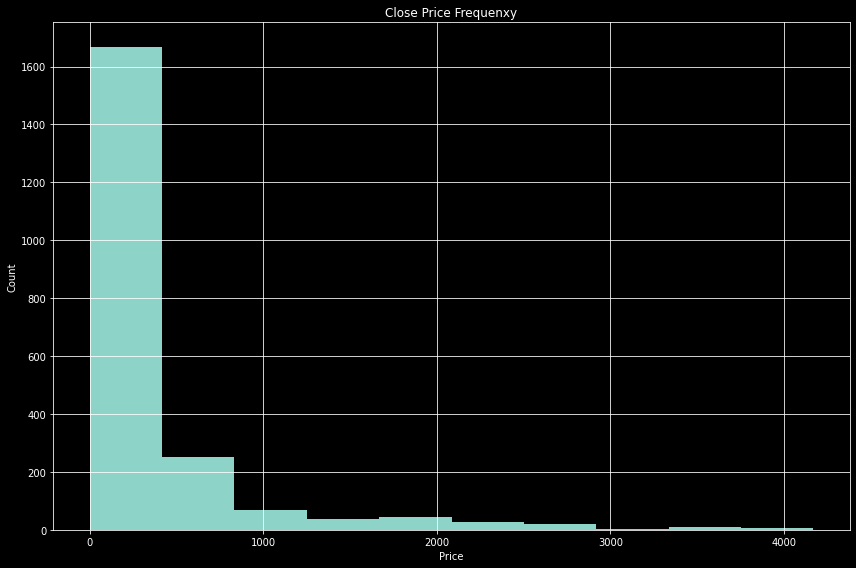

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
df.hist(column=['Close'], ax=ax)
ax.set_title('Close Price Frequenxy')
ax.set_xlabel('Price')
ax.set_ylabel('Count')
plt.tight_layout()
# plt.savefig('Histograms')


Above is a histogram of the frequency of occurences of price value. Their distribution exemplifies the volatility of the asset. The large majority of prices fall between 0 and 1000, however there are low-frequency instances of prices that are 2, 3, and 4 times the max value of that range. This shows that the price spiked and fell, never maintaining a high value for very long at all. 

### Clean up the Graphs

The original time series was very hard to interpret because the volume column has very large numbers that messed with the scale of the graph. In order to remedy this, we will plot the price data and the volume data seperately, and we will resample the Volume data in order

In [ ]:
# Plot the time series
fig = go.Figure()
col = ['Open', 'High', 'Low', 'Close']

# Add traces
for c in col:
    fig.add_trace(go.Scatter(x=df.index, y=df[c], mode='lines', name=f'{c}'))
fig.update_layout(
title='Price Data',
xaxis_title='Date',
yaxis_title='Price')
fig.show()
display(px.line(data_frame=df, x=df.index, y=df['Volume'], title='Volume Data'))

Target Variable

The trends of each series for each price related column (our target) are pretty much identical, so we can choose one of the features as a target variable and stick with that.
<br>

I will be using the "Close" price for Ethereum, which is the price of the asset at the close of normal trading hours at 4pm. 

### Resample Data (Week, Month, Year)

In [ ]:
# Create resampled DataFrame for more smooth visualization
quarterly_df = pd.DataFrame(df.resample('Q').mean())

# Plot the time series
fig = go.Figure()
col = ['Open', 'High', 'Low', 'Close']
# Add traces
for c in col:
    fig.add_trace(go.Scatter(x=quarterly_df.index, y=quarterly_df[c], mode='lines', name=f'{c}'))
fig.update_layout(
title='Price Data',
xaxis_title='Date',
yaxis_title='Price')
fig.show()
display(px.line(data_frame=quarterly_df, x=quarterly_df.index, y=quarterly_df['Volume'], title='Volume Data'))

### Autocorrelation Plots

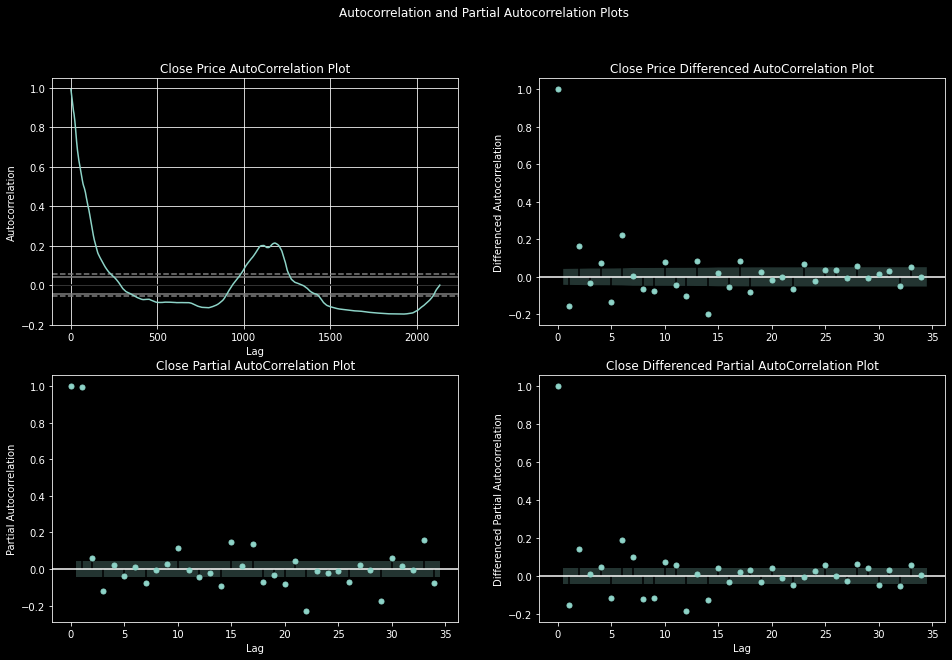

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

autocorrelation_plot(df['Close'].dropna(), ax=ax[0][0])
ax[0][0].set_title('Close Price AutoCorrelation Plot')

plot_acf(df['Close'].diff().dropna(), ax=ax[0][1])
ax[0][1].set_title('Close Price Differenced AutoCorrelation Plot')
ax[0][1].set_ylabel('Differenced Autocorrelation')

plot_pacf(df['Close'].dropna(), ax=ax[1][0])
ax[1][0].set_title('Close Partial AutoCorrelation Plot')
ax[1][0].set_xlabel('Lag')
ax[1][0].set_ylabel('Partial Autocorrelation')

plot_pacf(df['Close'].diff().dropna(), ax=ax[1][1])
ax[1][1].set_title('Close Differenced Partial AutoCorrelation Plot')
ax[1][1].set_xlabel('Lag')
ax[1][1].set_ylabel('Differenced Partial Autocorrelation')

plt.suptitle('Autocorrelation and Partial Autocorrelation Plots')
fig.show()
# plt.savefig('acf_plots')

### Test Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

# ADF Test for Non-differenced target variable
result = adfuller(df['Close'], autolag='AIC')
print('NON-DIFFERENCED TARGET VARIABLE')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

print(' ')
print(' ')

# ADF Test for Differenced target variable
result = adfuller(df['Close'].diff().dropna(), autolag='AIC')
print('DIFFERENCED TARGET VARIABLE')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


NON-DIFFERENCED TARGET VARIABLE
ADF Statistic: 1.0029061147236582
p-value: 0.9942965169904011
 
 
DIFFERENCED TARGET VARIABLE
ADF Statistic: -9.30090088786972
p-value: 1.113236335659705e-15


- A first-order difference is enough to stationarize the data

### Rolling Averages

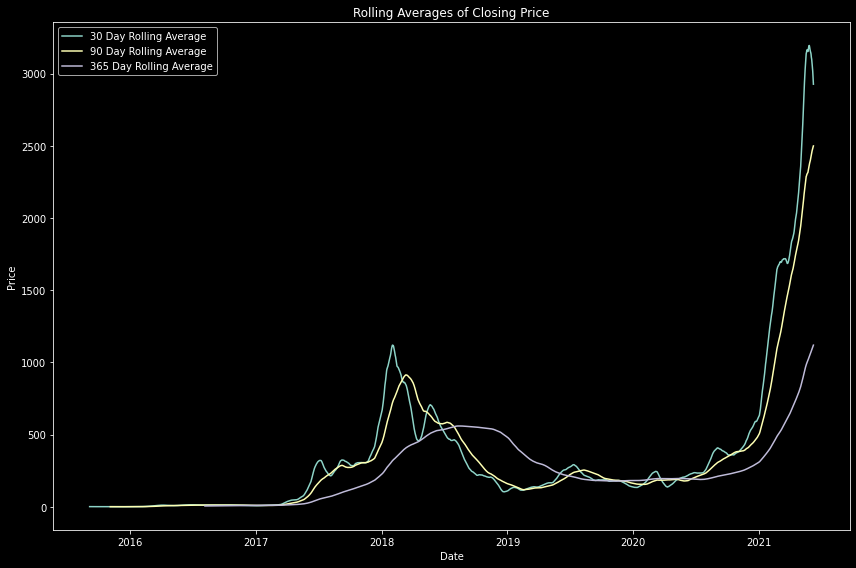

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
df_30d_rol = df['Close'].rolling(window = 30).mean()
df_90d_rol = df['Close'].rolling(window = 90).mean()
df_365d_rol = df['Close'].rolling(window = 365).mean()
ax.plot(df_30d_rol, label='30 Day Rolling Average')
ax.plot(df_90d_rol, label='90 Day Rolling Average')
ax.plot(df_365d_rol, label='365 Day Rolling Average')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Rolling Averages of Closing Price')
plt.legend()
plt.tight_layout()
plt.savefig('rolling_averages')

In [ ]:
# # Full compiled graph of 30-day, 90-day, and 365-day rolling averages

# fig = go.Figure()


# df_30d_rol = df['Close'].rolling(window = 30).mean()
# df_90d_rol = df['Close'].rolling(window = 90).mean()
# df_365d_rol = df['Close'].rolling(window = 365).mean()
# fig.add_trace(go.Scatter(x=df.index, y=df_30d_rol, mode='lines', name=f'30d Close'))
# fig.add_trace(go.Scatter(x=df.index, y=df_90d_rol, mode='lines', name=f'90d Close'))
# fig.add_trace(go.Scatter(x=df.index, y=df_365d_rol, mode='lines', name=f'365d Close'))

# fig.update_layout(
# title='Price Data',
# xaxis_title='Date',
# yaxis_title='Price',
# legend_title='Legend')
# fig.show()

The rolling averages calculated from three different windows (30, 90, 365) provide some more insight to the data. As the window increases in size, the rolling averages' values have very different values during the highly volatile periods of the price of Ethereum. This volatility resulted in each of these periods having wildly different minimum and maximum values, which results in rolling averages that also different by quite a lot. Unsurprisingly, the 30-day and 90-day rolling averages were the most closely related, especially during the first period of steep upwards trend. The prices did not reach magnitude differences during these windows that warranted such a drastic rolling average difference. However, at the end of our time period, the rolling averages end up differing in value by almost $500, which goes to show the extreme volatility that Ethereum experienced during this time period (the most recent months when Ethereum had a meteoric rise). In short summary, the 365-day moving average had the lowest average value because it generalized the most volatility, however its final value was very below the true price. The 30-day moving average had the highest value because it strongly accounted for the high volatility, and its final value was a little higher than the true price (the extreme upper values pulled the average upwards). The 90-day moving average was the closest to the true price, showing that it both accounted for and generalized the volatility the best of the three windows!

### Seasonality

Below are the price trends of Ethereum across all 12 months for each year since 2015. Looking at these price trends, there is no obvious seasonality to be seen, and therefore we will avoid using a SARIMAX model during our modeling process.

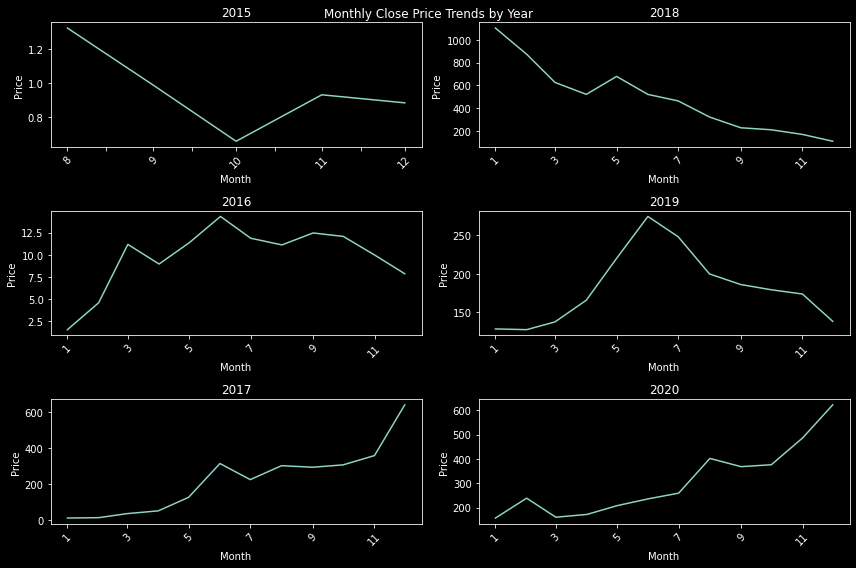

In [ ]:
# Investigate Monthly Seasonality per Year
plt.style.use('dark_background')

monthly_df = pd.DataFrame(df.resample('MS').mean())
fig, ax = plt.subplots(3,2, figsize=(12, 8))

ax[0][0].plot(monthly_df['Close']['2015'])
ax[0][0].set_title('2015')
ax[0][0].set_xlabel('Month')
ax[0][0].set_ylabel('Price')
ax[0][0].set_xticklabels(labels=['8', '', '9', '', '10', '', '11', '', '12'],rotation=45)

ax[1][0].plot(monthly_df['Close']['2016'])
ax[1][0].set_title('2016')
ax[1][0].set_xlabel('Month')
ax[1][0].set_ylabel('Price')
ax[1][0].set_xticklabels(labels=['1', '3', '5', '7', '9', '11'],rotation=45)

ax[2][0].plot(monthly_df['Close']['2017'])
ax[2][0].set_title('2017')
ax[2][0].set_xlabel('Month')
ax[2][0].set_ylabel('Price')
ax[2][0].set_xticklabels(labels=['1', '3', '5', '7', '9', '11'],rotation=45)

ax[0][1].plot(monthly_df['Close']['2018'])
ax[0][1].set_title('2018')
ax[0][1].set_xlabel('Month')
ax[0][1].set_ylabel('Price')
ax[0][1].set_xticklabels(labels=['1', '3', '5', '7', '9', '11'],rotation=45)

ax[1][1].plot(monthly_df['Close']['2019'])
ax[1][1].set_title('2019')
ax[1][1].set_xlabel('Month')
ax[1][1].set_ylabel('Price')
ax[1][1].set_xticklabels(labels=['1', '3', '5', '7', '9', '11'],rotation=45)

ax[2][1].plot(monthly_df['Close']['2020'])
ax[2][1].set_title('2020')
ax[2][1].set_xlabel('Month')
ax[2][1].set_ylabel('Price')
ax[2][1].set_xticklabels(labels=['1', '3', '5', '7', '9', '11'],rotation=45)

plt.suptitle('Monthly Close Price Trends by Year')
plt.tight_layout()
plt.savefig('monthly_price_trends')

Because the evidence of seasonality is rather weak and can most certainly be disputed, during the modeling process an ARIMA model with no seasonality inclusion will be test first, followed by a SARIMAX model.

### Findings

Ethereum prices follow what is called a "cyclical trend", which means that it has trends however these trends so no specific pattern of repetition. To illustrate this, we can look at two of the graphs, which are both displayed above. 

From the year 2015 to the first quarter of 2017, the price of Ethereum remained quite stationary, with a very strong rise starting between March and April, which led to a strong upwards trend that lasted throughout the rest of the year of 2017, bring the price to a maximum value of 826.82 by the end of the year. This constituted a 10,106 percent price increase from the minimum price of 8.17 in the year of 2017, which is by all standards a very strong upwards trend. The volume of trades also followed this trend quite closely, matching the sentiment idea that as an asset shoots up in price, more people attempt to join in on the ride, and hence more trades are made. After the year 2017, the price of Ethereum immediately started a strong downwards trend beginning in January of 2018, and by the end of 2018 the price had settled to a minimum value of 84.30, roughly a 94% drop from its all time high at the very beginning of 2018. Volume for the rest of 2018 remained on average higher than the two years afterwards and the year before because at first people were participating in frequent trades due to the meteoric rise in price, and then people continued to sell their coins over the year as the price tanked. From 2019 to mid-2020, the price once again mostly resumed the stationary trend that it had exemplified from 2015 to about a quarter of the way through 2017, indicating that perhaps people lost interest in the Ethereum block-chain, doubted its potential, or simply moved on to different investments. There was a sharp rise in prise to a little over 250 during 2019, but it just as quickly fell back to close to the minimum value of that year, failing to breakout of its strong downwards trend. The volume from 2019 to mid-2020 would never drop to the levels seen before the coin's meteoric rise, most likely because such a note-worthy event put Ethereum on the map permanently. During 2019, there was a sharp rise and fall in volume that mirrored the trend of the quick rise and fall of price during that year. 2019-2021 would be the period of time when Ethereum would consistently reflect a yearly upwards trend. Volume was higher than its ever been, and the price rose to an unprecedented level of roughly 4000. During this upwards trend, there were several downwards trends that occured during certain months of the years. They seemed to be relatively random, with no predictability in their occurences, highlighting the unstationarity of the price of Ethereum, and also the idea that the price follows a "cyclical trend". There are very clear bull and bear markets, however the trickly part is timing these.  



# Modeling

## Scale the Data

We are going to want to scale the data because of the massive magnitude differences between values. This will most likely improve the accuracy of our forecast

In [ ]:
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
scaled_data = pd.DataFrame(ss.fit_transform(df), columns=df.columns, index=df.index)

## Random-Walk

RMSE = 748.1175121746049


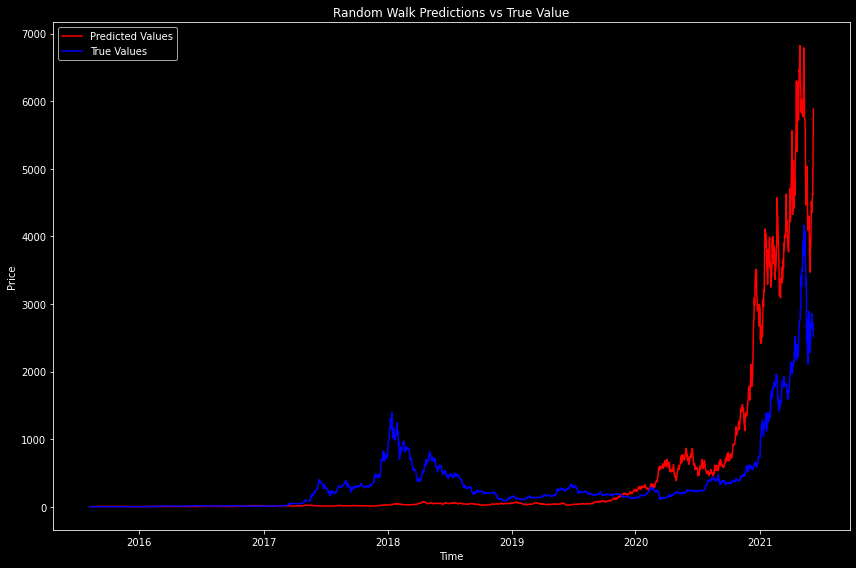

In [ ]:
## Walk
rwdata = pd.DataFrame(df['Close'], columns=['Close'])
rwdata['change'] = df['Close'].pct_change()
mean = rwdata['change'][1:].mean() 
sd = rwdata['change'][1:].std()

## Predict
model = {}
model['Prediction'] = [rwdata['Close'][0]]
for time in range(1, len(rwdata)):
    old = model['Prediction'][time -1] 
    new_price = old*(1+ mean) + old*sd*np.random.normal(0,1) 
    model['Prediction'].append(new_price)
    
## Plot
rwdf = pd.DataFrame(model, index=rwdata.index) 

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(rwdf, label='Predicted Values', color='Red')
ax.plot(rwdata['Close'], label='True Values', color='Blue')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Random Walk Predictions vs True Value')
plt.legend()
plt.tight_layout()

rmse = math.sqrt(mean_squared_error(rwdf, rwdata['Close']))
print(f'RMSE = {rmse}')

The model was run multiple times, in an attempt to aquire the best possible model for the problem. The best random-walk achieved had an RMSE of 323.097. Since the business strategy we are focusing on is day-trading, it is preferable to have tighter margins of error, because we are not holding for long periods of time and therefore a wrong guess affects our success more strongly.

## ARIMA Model

In [ ]:
### Train-Test-Split the Non-Scaled Data
y_train = df['Close'][:'2019-06-13']
y_test = df['Close']['2019-06-14':] 
x_train = df.index[:1407]
x_test = df.index[1407:]

###
y_train_scaled = scaled_data['Close'][:'2019-06-13']
y_test_scaled = scaled_data['Close']['2019-06-14':] 

In [ ]:
import pmdarima as pm
model = pm.auto_arima(y_train_scaled, start_P=0, d=2, start_q=0, max_p=5, max_d=5, max_q=5, 
                      D=1, start_Q=0, max_D=5, max_Q=5, m=12, seasonal=True, error_action='warn',
                      trace=True, supress_warnings=True, stepwise=False)
model.summary()

 ARIMA(0,2,0)(0,1,0)[12]             : AIC=-8784.166, Time=0.50 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=-9702.335, Time=0.96 sec
 ARIMA(0,2,0)(0,1,2)[12]             : AIC=inf, Time=18.61 sec
 ARIMA(0,2,0)(0,1,3)[12]             : AIC=inf, Time=15.95 sec
 ARIMA(0,2,0)(0,1,4)[12]             : AIC=inf, Time=16.26 sec
 ARIMA(0,2,0)(0,1,5)[12]             : AIC=inf, Time=76.53 sec
 ARIMA(0,2,0)(1,1,0)[12]             : AIC=-9174.729, Time=1.90 sec
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=inf, Time=4.93 sec
 ARIMA(0,2,0)(1,1,2)[12]             : AIC=inf, Time=9.88 sec
 ARIMA(0,2,0)(1,1,3)[12]             : AIC=inf, Time=32.77 sec
 ARIMA(0,2,0)(1,1,4)[12]             : AIC=inf, Time=32.74 sec
 ARIMA(0,2,0)(2,1,0)[12]             : AIC=-9427.726, Time=2.28 sec
 ARIMA(0,2,0)(2,1,1)[12]             : AIC=inf, Time=9.48 sec
 ARIMA(0,2,0)(2,1,2)[12]             : AIC=inf, Time=13.09 sec
 ARIMA(0,2,0)(2,1,3)[12]             : AIC=inf, Time=31.28 sec
 ARIMA(0,2,1)(0,1,0)[12]             :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1407
Model:             SARIMAX(0, 2, 2)x(0, 1, [1], 12)   Log Likelihood                5267.394
Date:                              Wed, 23 Jun 2021   AIC                         -10526.788
Time:                                      01:38:58   BIC                         -10505.831
Sample:                                           0   HQIC                        -10518.952
                                             - 1407                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7360      0.009    -79.321      0.000      -0.754      -0.718
ma.L2         -0.1513      0.009    -16.461      0.000      -0.169      -0.133
ma.S.L12      -0.8781      0.009    -96.676      0.000      -0.896      -0.860
sigma2      3.015e-05   3.66e-07     82.320      0.000    2.94e-05    3.09e-05
===================================================================================
Ljung-Box (L1) (Q):                  38.50   Jarque-Bera (JB):             32490.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             869.54   Skew:                            -1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

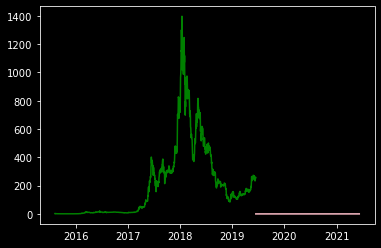

RMSE = 1053.2547788963773


In [ ]:
# make your forecasts
prediction = pd.DataFrame(model.predict(n_periods=726), index=y_test.index)
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y_test.shape[0])
plt.plot(y_train, c='green')
plt.plot(prediction, c='pink')
plt.show()

rmse = math.sqrt(mean_squared_error(prediction, y_test))
print(f'RMSE = {rmse}')

The ARIMA model performed poorly for the data provided. This can almost certainly be attributed to the exaggerated volatility of Ethereum prices. The period of time that ARIMA was trained on showed an interesting trend. The price remained low, then spiked to a value that was much higher than before, and just as quickly fell down to a very low value again and remained there for quite some time. In other words, it was relatively stationary, then had a steep upwards trend, a steep downwards trend, and then remained relatively stationary again. The two main determinants of ARIMA predicitons, past values and moving average, are very hard to predict upon because thei values vary by so much.

## Prophet

In [ ]:
### Import Prophet
from fbprophet import Prophet


### Create Prophet compatible DataFrame
data = df.reset_index()[['Date', 'Close', 'Volume', 'MarketCap']].rename(columns={'Date':'ds', 'Close':'y', 'Volume':'Volume', 'MarketCap':'MarketCap'})
data['btc'] = df2['Open'][830:2963].values
### Train-Test-Split the data
train = data[:1407]
test = data[1407:]

First, Prophet will be used as a univariate regression model, with the sole determinant variable being our target variable, the "Close" price.

497.91963965025184


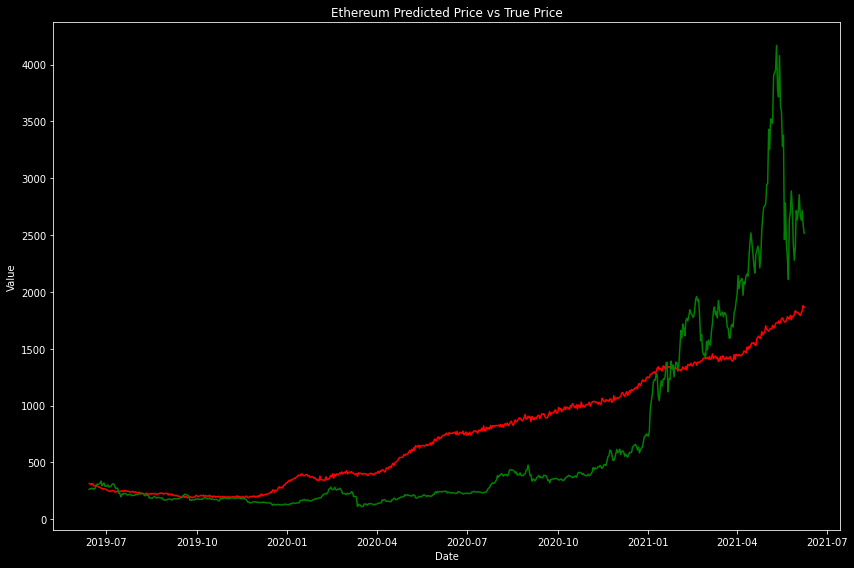

In [ ]:
### Predictions using training data
m = Prophet(daily_seasonality=False)
m.fit(train)
future = m.make_future_dataframe(periods=len(test), freq='D')[1407:]
forecast = m.predict(future)


### Predictions DataFrame
pred = pd.DataFrame(forecast.yhat_upper[-726:])
pred.index=forecast.ds[-726:]
pred

### Test data DataFrame
testplot = pd.DataFrame(test.y)
testplot.index=test.ds

### Plot Test vs Predictions
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pred, label='Predictions', color='red')
ax.plot(testplot, label='True', color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Ethereum Predicted Price vs True Price')
plt.tight_layout()

### Calculate RMSE
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(pred, testplot))

# display(future)
# display(pred)
print(rmse)

The univariate model had an RMSE of 505.761
To try and improve this model's performance, a second regressor variable will be added into the model's calculations. This will be the "Volume" data found in the same imported data as the "Close" prices.

564.4727068246807


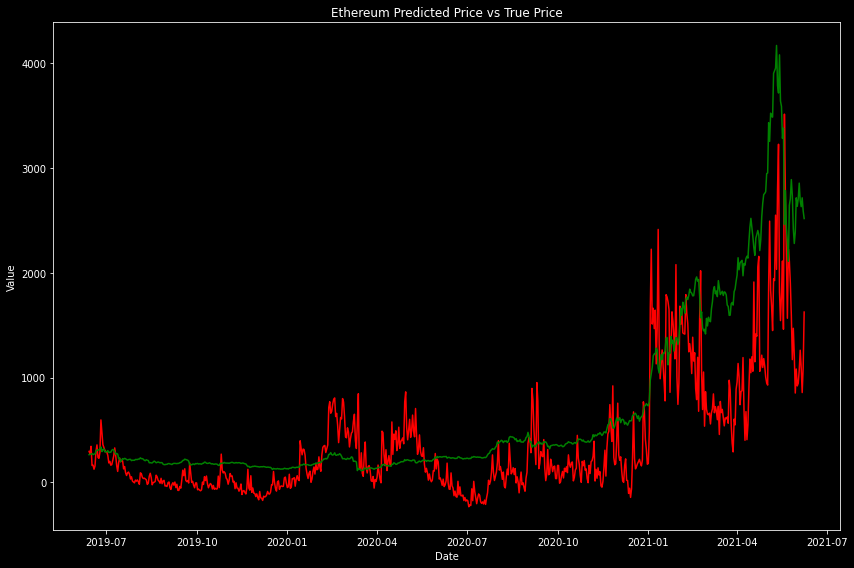

In [ ]:
### Predictions using training data
m = Prophet(daily_seasonality=False)
m.add_regressor('Volume')
m.fit(train)
future = m.make_future_dataframe(periods=len(test), freq='D')[1407:]
future['Volume'] = test['Volume'].values
forecast = m.predict(future)


### Predictions DataFrame
pred = pd.DataFrame(forecast.yhat_upper[-726:])
pred.index=forecast.ds[-726:]
pred

### Test data DataFrame
testplot = pd.DataFrame(test.y)
testplot.index=test.ds

### Plot Test vs Predictions
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pred, label='Predictions', color='red')
ax.plot(testplot, label='True', color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Ethereum Predicted Price vs True Price')
plt.tight_layout()

### Calculate RMSE
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(pred, testplot))

# display(future)
# display(pred)
print(rmse)

The RMSE of the new model was 505.584

Adding one additional regressor to the model seemed to improve its performance, but only ever so slightly. Let's add one more regressor to see if it can help improve the model. We will use another variable that was found in the imported data that cannot be directly derived from the price; "Market Cap"

279.0646012370323


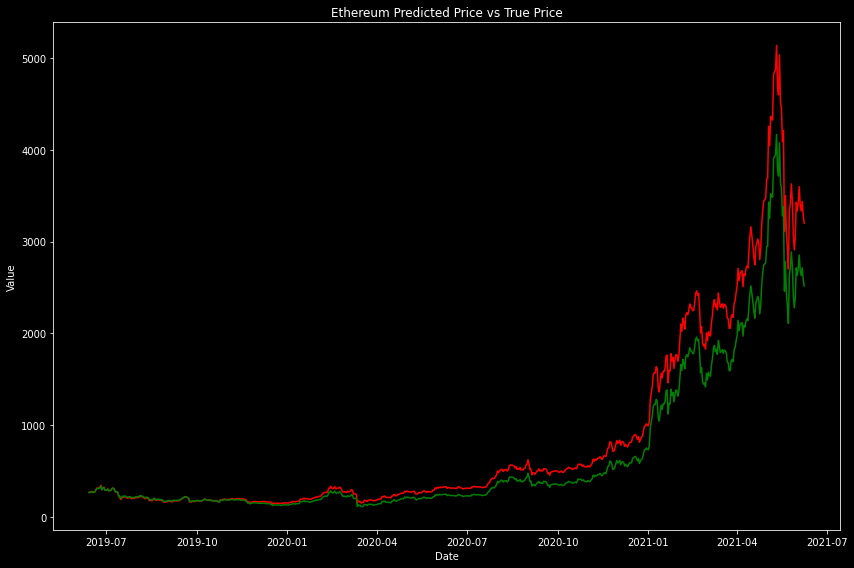

In [ ]:
### Predictions using training data
m = Prophet(daily_seasonality=False)
m.add_regressor('Volume')
m.add_regressor('MarketCap')
m.fit(train)
future = m.make_future_dataframe(periods=len(test), freq='D')[1407:]
future['Volume'] = test['Volume'].values
future['MarketCap'] = test['MarketCap'].values
forecast = m.predict(future)


### Predictions DataFrame
pred = pd.DataFrame(forecast.yhat_upper[-726:])
pred.index=forecast.ds[-726:]
pred

### Test data DataFrame
testplot = pd.DataFrame(test.y)
testplot.index=test.ds

### Plot Test vs Predictions
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pred, label='Predictions', color='red')
ax.plot(testplot, label='True', color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Ethereum Predicted Price vs True Price')
plt.tight_layout()

### Calculate RMSE
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(pred, testplot))

# display(future)
# display(pred)
print(rmse)

The RMSE score for the model with two additional regressor variables was 276.252

Adding a second regressor improved our RMSE metric by a very considerable amount.

This begs the question; "Will adding one or two more regressors improve the model even further?"

Let's find out.

In order to do this, we will have to use new data imported from the same source as the original data used; CoinMarketCap.com



*   We will use BitCoin close prices on the corresponding dates as our third regressor variable.



286.8108924627803


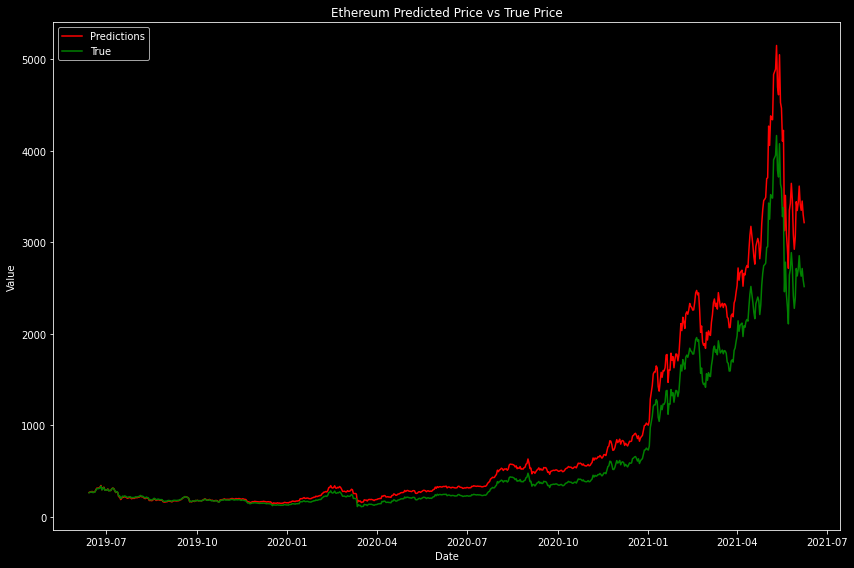

In [ ]:
### Predictions using training data
m = Prophet(daily_seasonality=False)
m.add_regressor('Volume')
m.add_regressor('MarketCap')
m.add_regressor('btc')
m.fit(train)
future = m.make_future_dataframe(periods=len(test), freq='D')[1407:]
future['Volume'] = test['Volume'].values
future['MarketCap'] = test['MarketCap'].values
future['btc'] = test['btc'].values
# future['Bitcoin_Close'] = test['Close']  ### HAVE TO SCRAPE BITCOIN DATA FOR THIS!!!
forecast = m.predict(future)


### Predictions DataFrame
pred = pd.DataFrame(forecast.yhat_upper[-726:])
pred.index=forecast.ds[-726:]
pred

### Test data DataFrame
testplot = pd.DataFrame(test.y)
testplot.index=test.ds

### Plot Test vs Predictions
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pred, label='Predictions', color='red')
ax.plot(testplot, label='True', color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Ethereum Predicted Price vs True Price')
ax.legend()
plt.tight_layout()

### Calculate RMSE
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(pred, testplot))

# display(future)
# display(pred)
print(rmse)

## Deep Learning

### LSTM

In [ ]:
data = np.asarray(df['Close']).reshape(-1,1)

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# split into train and test sets
train_size = int(len(data) * 0.6)
test_size = len(data) - train_size

train = data[0:train_size,:]
test = data[train_size:len(data),:]

In [ ]:
# Use TimeseriesGenerator to create the samples
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 90

train_data = TimeseriesGenerator(train, train,
    length=n_input,
    batch_size=128)

test_data = TimeseriesGenerator(test, test,
    length=n_input,
    batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
import tensorflow as tf

All models will be trained on the training data and then their RSME scores will be calculated using the testing data. 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 256)               265216    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 265,473
Trainable params: 265,473
Non-trainable params: 0
_________________________________________________________________


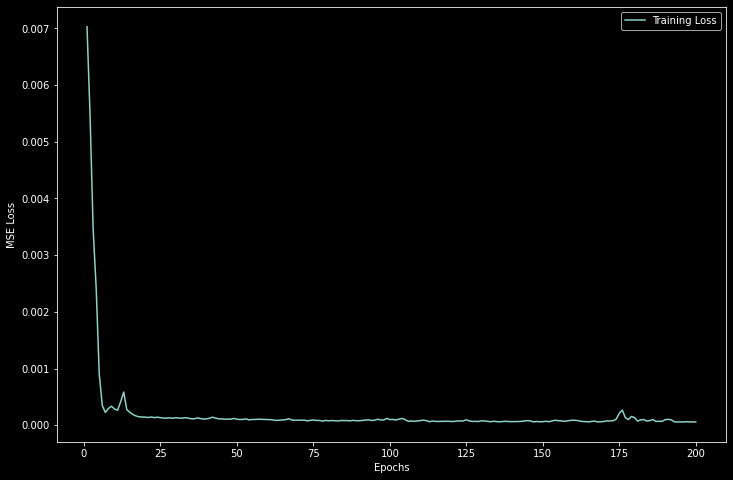

(1189, 1)
(764, 1)


,Close,Pred
Date,,
2019-05-07,169.80,162.556183
2019-05-08,170.95,164.378494
2019-05-09,170.29,165.609360
2019-05-10,173.14,165.822250
2019-05-11,194.30,166.687195
...,...,...
2021-06-04,2688.19,2694.465332
2021-06-05,2630.58,2685.387451
2021-06-06,2715.09,2609.728027


RMSE = 86.85856852465967


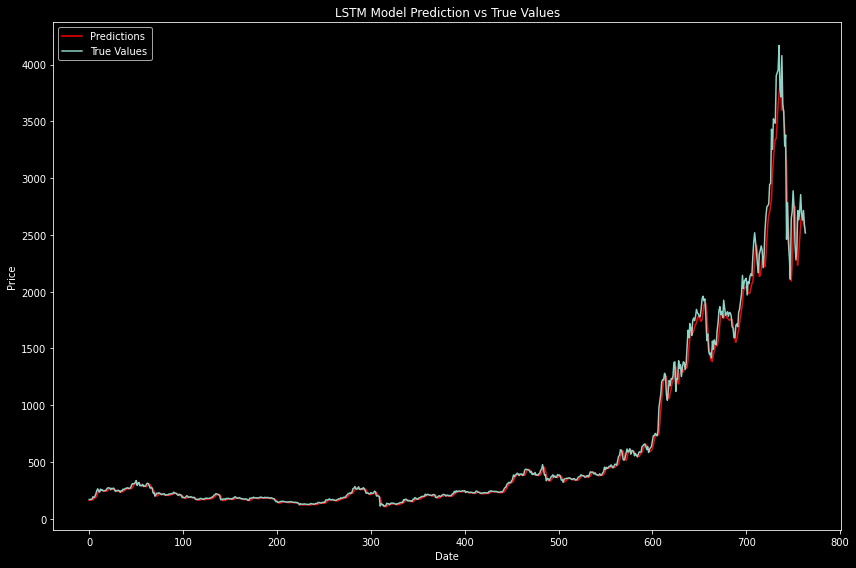

In [ ]:
# Model 1

model1 = Sequential()
model1.add(LSTM(256, return_sequences=False,
                  input_shape=(10,2)))
model1.add(Dropout(0.2))
model1.add(Dense(units=1))

# Compile the model
model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanSquaredError'])

# Summarize the model
model1.summary()
history = model1.fit_generator(train_data, epochs=200, verbose=0)

# Plot loss by epoch
loss = history.history['loss']
epochs = range(1, 201)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss)
plt.legend(['Training Loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show();

# Predict
train_pred = model1.predict_generator(train_data)
test_pred = model1.predict_generator(test_data)

# Inverse the transformation we did earlier so we have the true values of the predictions
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Helper function
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

# Get the y values
train_output = get_y_from_generator(train_data)
test_output = get_y_from_generator(test_data)

# Reverse transform those
train_output = scaler.inverse_transform(train_output)
test_output = scaler.inverse_transform(test_output)


# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test_pred, label='Predictions', color='red')
ax.plot(test_output, label="True Values")
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
ax.set_title('LSTM Model Prediction vs True Values')
plt.tight_layout()
plt.savefig('lstm')

# Show predictions and RMSE
rmse_df1 = pd.DataFrame(df['Close'], index=df.index[1369:])
rmse_df1['Pred'] = test_pred
display(rmse_df1)
rmse = math.sqrt(mean_squared_error(rmse_df1['Close'], rmse_df1['Pred']))
print(f'RMSE = {rmse}')

The second model will also have a single LSTM layer and 256 units, however a discrete dropout layer will also be added.

100 Epochs



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               265216    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 265,473
Trainable params: 265,473
Non-trainable params: 0
_________________________________________________________________


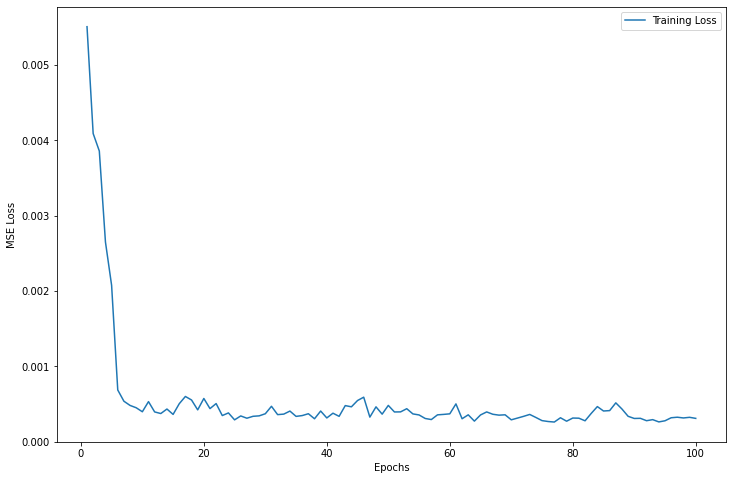

(1189, 1)
(764, 1)


,Close,Pred
Date,,
2019-05-07,169.80,145.502274
2019-05-08,170.95,146.396439
2019-05-09,170.29,147.344574
2019-05-10,173.14,148.073669
2019-05-11,194.30,149.057648
...,...,...
2021-06-04,2688.19,1854.424805
2021-06-05,2630.58,1858.958130
2021-06-06,2715.09,1856.833984


RMSE = 320.34766611276393


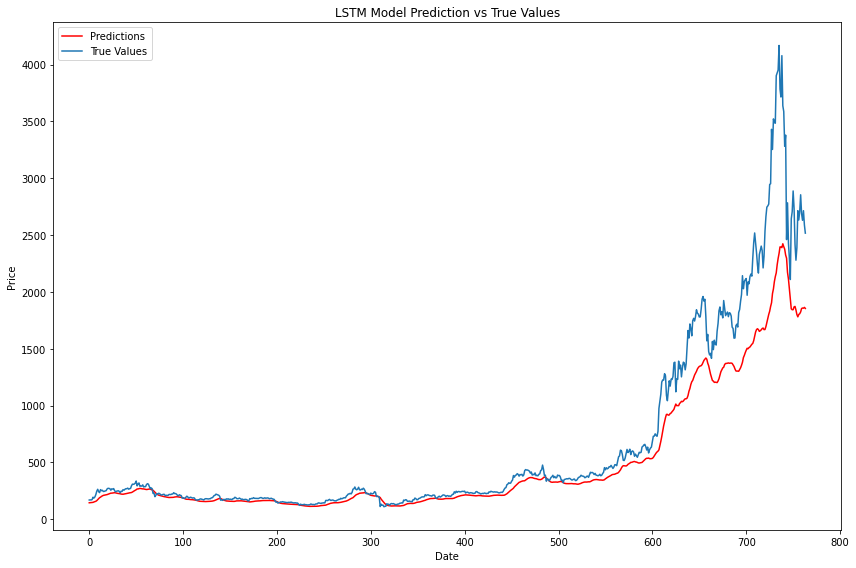

In [ ]:
# Model 2

model2 = Sequential()
model2.add(LSTM(256, return_sequences=False,
                  input_shape=(10,2), dropout=0.2))
model2.add(Dropout(0.2))
model2.add(Dense(units=1))

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanSquaredError'])

# Summarize the model
model2.summary()
history = model2.fit_generator(train_data, epochs=100, verbose=0)

# Plot loss by epoch
loss = history.history['loss']
epochs = range(1, 101)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss)
plt.legend(['Training Loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show();

# Predict
train_pred = model2.predict_generator(train_data)
test_pred = model2.predict_generator(test_data)

# Inverse the transformation we did earlier so we have the true values of the predictions
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Helper function
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

# Get the y values
train_output = get_y_from_generator(train_data)
test_output = get_y_from_generator(test_data)

# Reverse transform those
train_output = scaler.inverse_transform(train_output)
test_output = scaler.inverse_transform(test_output)


# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test_pred, label='Predictions', color='red')
ax.plot(test_output, label="True Values")
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
ax.set_title('LSTM Model Prediction vs True Values')
plt.tight_layout()
# plt.savefig('lstm')

# Show predictions and RMSE
rmse_df2 = pd.DataFrame(df['Close'], index=df.index[1369:])
rmse_df2['Pred'] = test_pred
display(rmse_df2)
rmse = math.sqrt(mean_squared_error(rmse_df2['Close'], rmse_df2['Pred']))
print(f'RMSE = {rmse}')

The third model will be more complex than the previous two. The model will have three LSTM layers rather than just one, with each layer having 256 units.

30 Epochs

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 10, 256)           265216    
_________________________________________________________________
lstm_19 (LSTM)               (None, 10, 256)           525312    
_________________________________________________________________
lstm_20 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 1,316,097
Trainable params: 1,316,097
Non-trainable params: 0
_________________________________________________________________


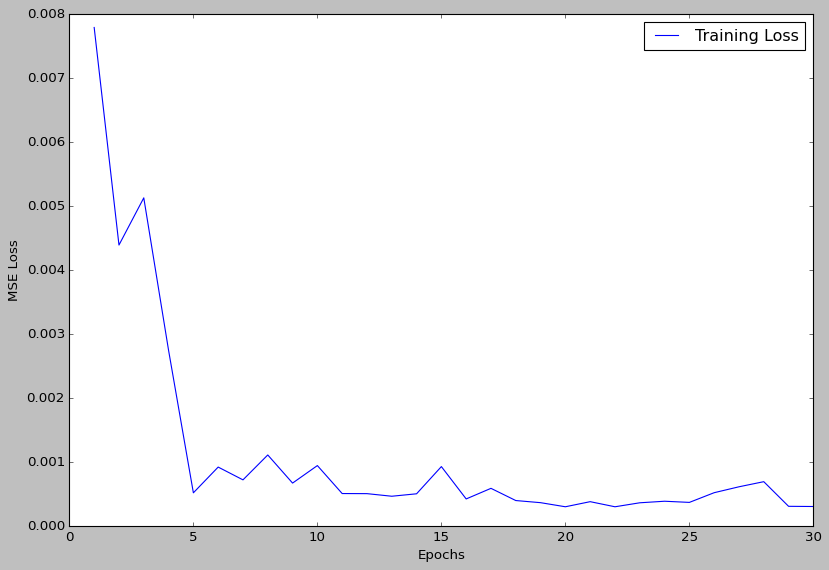

(1189, 1)
(764, 1)


,Close,Pred
dt,,
2019-05-07,169.80,173.351135
2019-05-08,170.95,174.282211
2019-05-09,170.29,175.338318
2019-05-10,173.14,176.389633
2019-05-11,194.30,177.476547
...,...,...
2021-06-04,2688.19,2232.976807
2021-06-05,2630.58,2248.329834
2021-06-06,2715.09,2259.835938


RMSE = 201.18370469167448


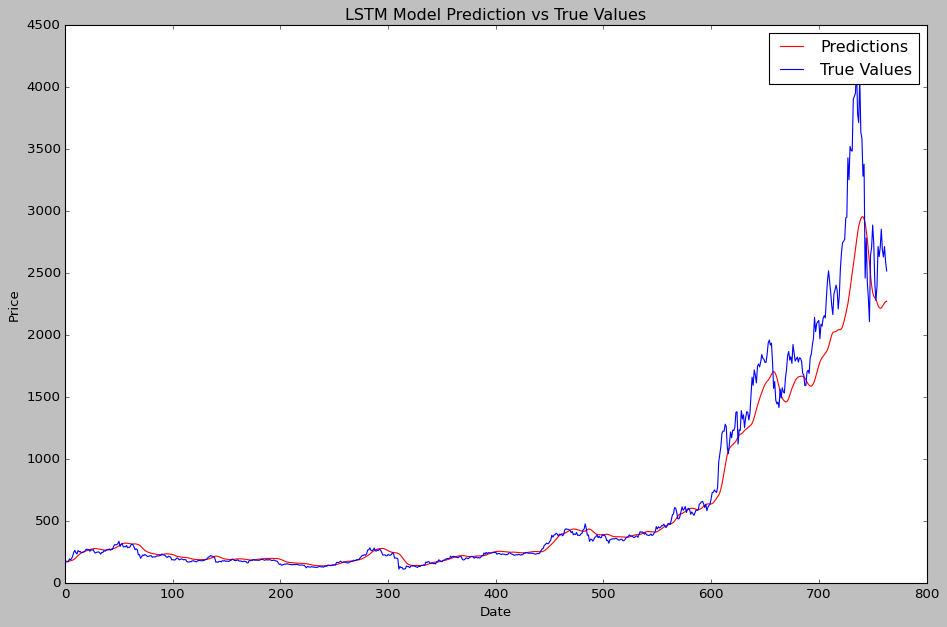

In [ ]:
# Model 3 (Greater complexity, dropout is specified inside the LSTM model parameters)
# Read this https://stackoverflow.com/questions/50720670/using-dropout-with-keras-and-lstm-gru-cell to understand the difference
## between a dropout LAYER and the dropout PARAMETER in the LSTM function

# Create the model!
model3 = Sequential()
model3.add(LSTM(units=256, return_sequences=True,
                  input_shape=(10,2), dropout=0.2))
model3.add(LSTM(units=256, return_sequences=True,
                  dropout=0.2))
model3.add(LSTM(units=256, dropout=0.2))
model3.add(Dense(units=1))

# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanSquaredError'])

# Summarize the model
model3.summary()

# Run the model
history = model3.fit_generator(train_data, epochs=30, verbose=0)

# Predict the data using the model!
train_pred = model3.predict_generator(train_data)
test_pred = model3.predict_generator(test_data)

# Inverse the transformation we did earlier so we have the true values of the predictions
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Plot loss per epoch
loss = history.history['loss']
epochs = range(1, 31)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss)
plt.legend(['Training Loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show();

# Helper function
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

# Get the y values
train_output = get_y_from_generator(train_data)
test_output = get_y_from_generator(test_data)

# Reverse transform those
train_output = scaler.inverse_transform(train_output)
test_output = scaler.inverse_transform(test_output)


# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test_pred, label='Predictions', color='red')
ax.plot(test_output, label="True Values")
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
ax.set_title('LSTM Model Prediction vs True Values')
plt.tight_layout()
plt.savefig('lstm')

# Show predictions and RMSE
rmse_df3 = pd.DataFrame(df['Close'], index=df.index[1369:])
rmse_df3['Pred'] = test_pred
display(rmse_df3)
rmse = math.sqrt(mean_squared_error(rmse_df3['Close'], rmse_df3['Pred']))
print(f'RMSE = {rmse}')

Originally, 30 epochs were used for the model. The "Loss vs Epoch" graph suggested that the loss could further be reduced, as it still had a clear downward trend rather than evening out in order to show the values of the loss converged.

The fourth mode will be identical to the third, however the amount of epochs will be increased to 100

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 256)           265216    
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 256)           525312    
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 1,316,097
Trainable params: 1,316,097
Non-trainable params: 0
_________________________________________________________________


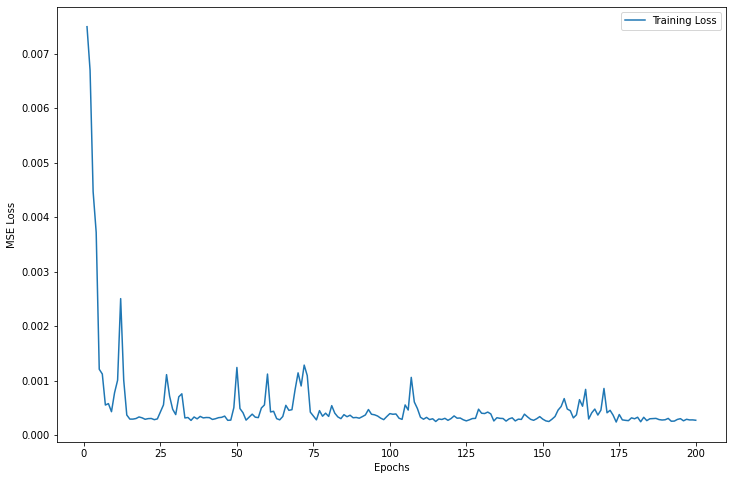

(1189, 1)
(764, 1)


,Close,Pred
Date,,
2019-05-07,169.80,144.841034
2019-05-08,170.95,145.629623
2019-05-09,170.29,146.378052
2019-05-10,173.14,146.971024
2019-05-11,194.30,147.864105
...,...,...
2021-06-04,2688.19,1995.412231
2021-06-05,2630.58,1993.224121
2021-06-06,2715.09,1983.383911


RMSE = 287.8007255567777


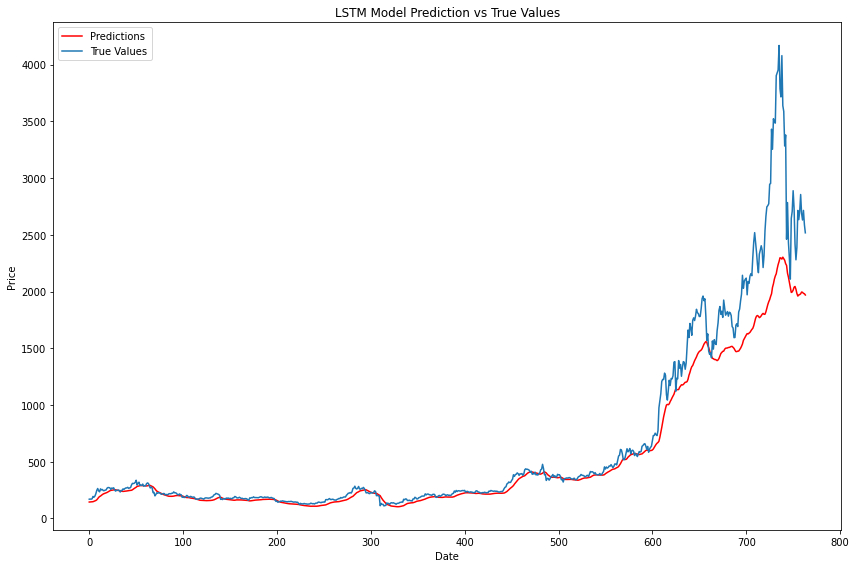

In [ ]:
# Model 4 (same model, more epochs)

# Create the model!
model4 = Sequential()
model4.add(LSTM(units=256, return_sequences=True,
                  input_shape=(10,2), dropout=0.2))
model4.add(LSTM(units=256, return_sequences=True,
                  dropout=0.2))
model4.add(LSTM(units=256, dropout=0.2))
model4.add(Dense(units=1))

# Compile the model
model4.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanSquaredError'])

# Summarize the model
model4.summary()

# Fit the model
history = model4.fit_generator(train_data, epochs=200, verbose=0)

# Predict the data using the model!
train_pred = model4.predict_generator(train_data)
test_pred = model4.predict_generator(test_data)

# Inverse the transformation we did earlier so we have the true values of the predictions
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Plot loss per epoch
loss = history.history['loss']
epochs = range(1, 201)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss)
plt.legend(['Training Loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show();

# Helper function
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

# Get the y values
train_output = get_y_from_generator(train_data)
test_output = get_y_from_generator(test_data)

# Reverse transform those
train_output = scaler.inverse_transform(train_output)
test_output = scaler.inverse_transform(test_output)


# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test_pred, label='Predictions', color='red')
ax.plot(test_output, label="True Values")
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
ax.set_title('LSTM Model Prediction vs True Values')
plt.tight_layout()
plt.savefig('lstm')

# Show predictions and RMSE
rmse_df4 = pd.DataFrame(df['Close'], index=df.index[1369:])
rmse_df4['Pred'] = test_pred
display(rmse_df4)
rmse = math.sqrt(mean_squared_error(rmse_df4['Close'], rmse_df4['Pred']))
print(f'RMSE = {rmse}')# Predict the data using the model!

The fifth and final model will be identical to the fourth model, however the number of units per layer will be increased to 2048.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 2048)          16801792  
_________________________________________________________________
dropout (Dropout)            (None, 10, 2048)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 2048)          33562624  
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 2048)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 2048)              33562624  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

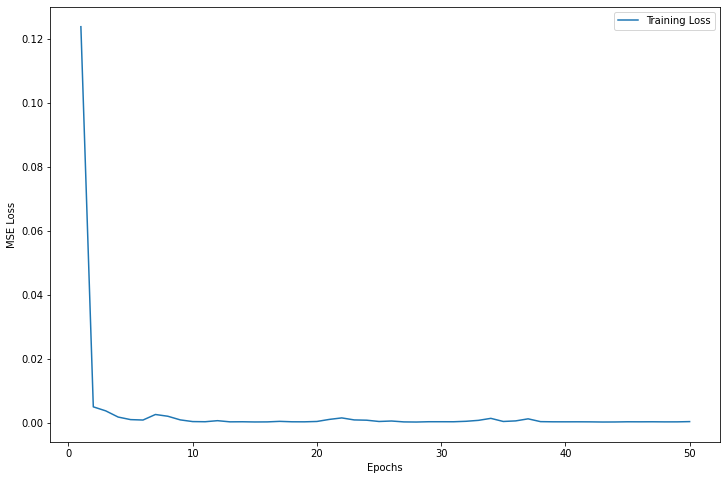

(1189, 1)
(764, 1)


,Close,Pred
Date,,
2019-05-07,169.80,151.342651
2019-05-08,170.95,152.354904
2019-05-09,170.29,153.072327
2019-05-10,173.14,153.775528
2019-05-11,194.30,154.552979
...,...,...
2021-06-04,2688.19,1988.932739
2021-06-05,2630.58,1995.205078
2021-06-06,2715.09,1990.319580


RMSE = 284.6646972825068


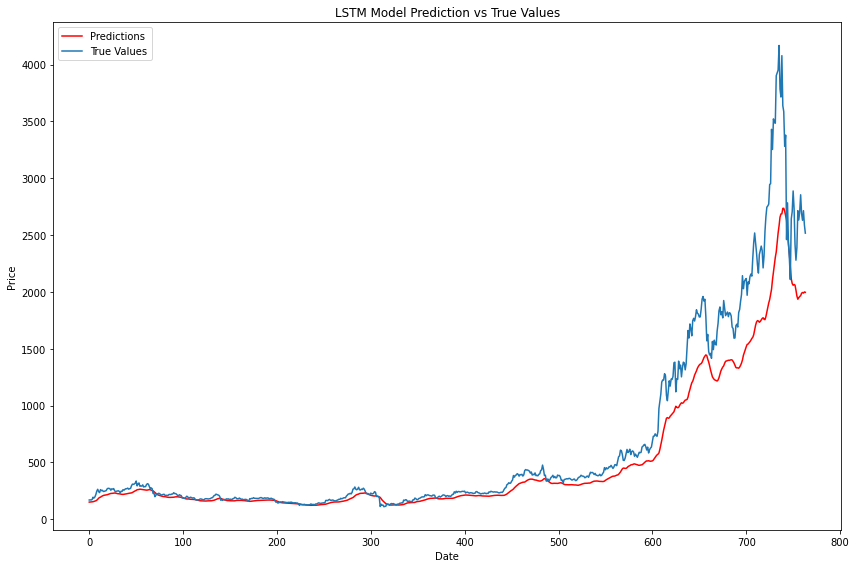

In [ ]:
# Model 5


# Create the model!
from keras.layers import Dropout
model5 = Sequential()
model5.add(LSTM(2048, return_sequences=True,
                  input_shape=(10,2), dropout=0.2))
model5.add(Dropout(0.2))
model5.add(LSTM(2048, return_sequences=True, dropout=0.2))
model5.add(Dropout(0.2))
model5.add(LSTM(2048, return_sequences=False, dropout=0.2))
model5.add(Dropout(0.2))
model5.add(Dense(units=1))

# Compile the model
model5.compile(optimizer='adam', loss='mean_squared_error')

# Summarize the model
model5.summary()

# Fit the model
history = model5.fit_generator(train_data, epochs=50, verbose=0)

# Plot loss by epoch
loss = history.history['loss']
epochs = range(1, len(history.history['loss'])+1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss)
plt.legend(['Training Loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show();

# Predict
train_pred = model5.predict_generator(train_data)
test_pred = model5.predict_generator(test_data)

# Inverse the transformation we did earlier so we have the true values of the predictions
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Helper function
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

# Get the y values
train_output = get_y_from_generator(train_data)
test_output = get_y_from_generator(test_data)

# Reverse transform those
train_output = scaler.inverse_transform(train_output)
test_output = scaler.inverse_transform(test_output)


# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test_pred, label='Predictions', color='red')
ax.plot(test_output, label="True Values")
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
ax.set_title('LSTM Model Prediction vs True Values')
plt.tight_layout()
plt.savefig('lstm')

# Show predictions and RMSE
rmse_df5 = pd.DataFrame(df['Close'], index=df.index[1369:])
rmse_df5['Pred'] = test_pred
display(rmse_df5)
rmse = math.sqrt(mean_squared_error(rmse_df5['Close'], rmse_df5['Pred']))
print(f'RMSE = {rmse}')

#### Overall Results

The best performing model was the model with:
- 1 LSTM layer
- 256 units per layer
- Dropout specified within the LSTM layer rather than being a discrete layer itself

The model predicted higher than actual prices for roughly the first 550 timesteps, and then predicted lower than actual prices for the remaining timesteps. 

Overall, the model predictions followed the trend of the actual prices quite closely, correctly timing (although very roughly) the sharp rises and falls in the price of Ethereum. Volatility is what makes trading Ethereum so difficult, and a model that can even roughly predict the highly volatile time periods of the asset can be very useful.

## Summary of Results


| Model          | RMSE   |
|----------------|--------|
| Random Walk    | 493.49 |
|                         |
| Auto-ARIMA     | 1053.25|
|                         |
| Prophet(No Exo)| 506.81 |  
|                         |
| Prophet(Exo)   | 277.92 |
|                         |
| LSTM (No Exo)  | 135.55 |

## Profit/Revenue Calculations

Now that the models have been constructed, let's calculate the net profit made from three different trading strategies:

1. LSTM strategy

2. Simple Moving Average Strategy

3. Buy-and-Hold Strategy

( For the SMA strategy, we will be using the fastquant package. It's details can be found here: https://pypi.org/project/fastquant/#description )

### LSTM

In [1]:
# investments = 100000
# Buy = 0
# Sell = 0
# for index, pred in enumerate(rmse_df1['Pred']):
#   if index==763:
#     break
#   elif rmse_df1['Pred'][int(index+1)] > pred:
#     investments = investments + rmse_df1['Close'][index]
#     # print('Buy')
#     Buy += 1
#   elif rmse_df1['Pred'][index+1] < pred:
#     investments = investments - rmse_df1['Close'][index]
#     # print('Sell')
#     Sell += 1
# print(investments)
# print(f'Total Buy Orders: {Buy}')
# print(f'Total Sell Orders: {Sell}')

# THIS NEEDS TO BE REDONE

#### Strategy (UNDER REVIEW)
The LSTM Trading Strategy is described as such:

*   When the model predicts a rise in value for the following day, one unit of Ethereum is bought

*   When the model predicts a decline in value for the following day, one unit of Ethereum is sold

#### Overall Performance

    * The final portfolio value of  
    * This is a total profit of 
    * Increased original investment by 


THE ABOVE CELLS NEED TO BE REDONE. BETTER CALCULATIONS

### Exponential Moving Average Strategy

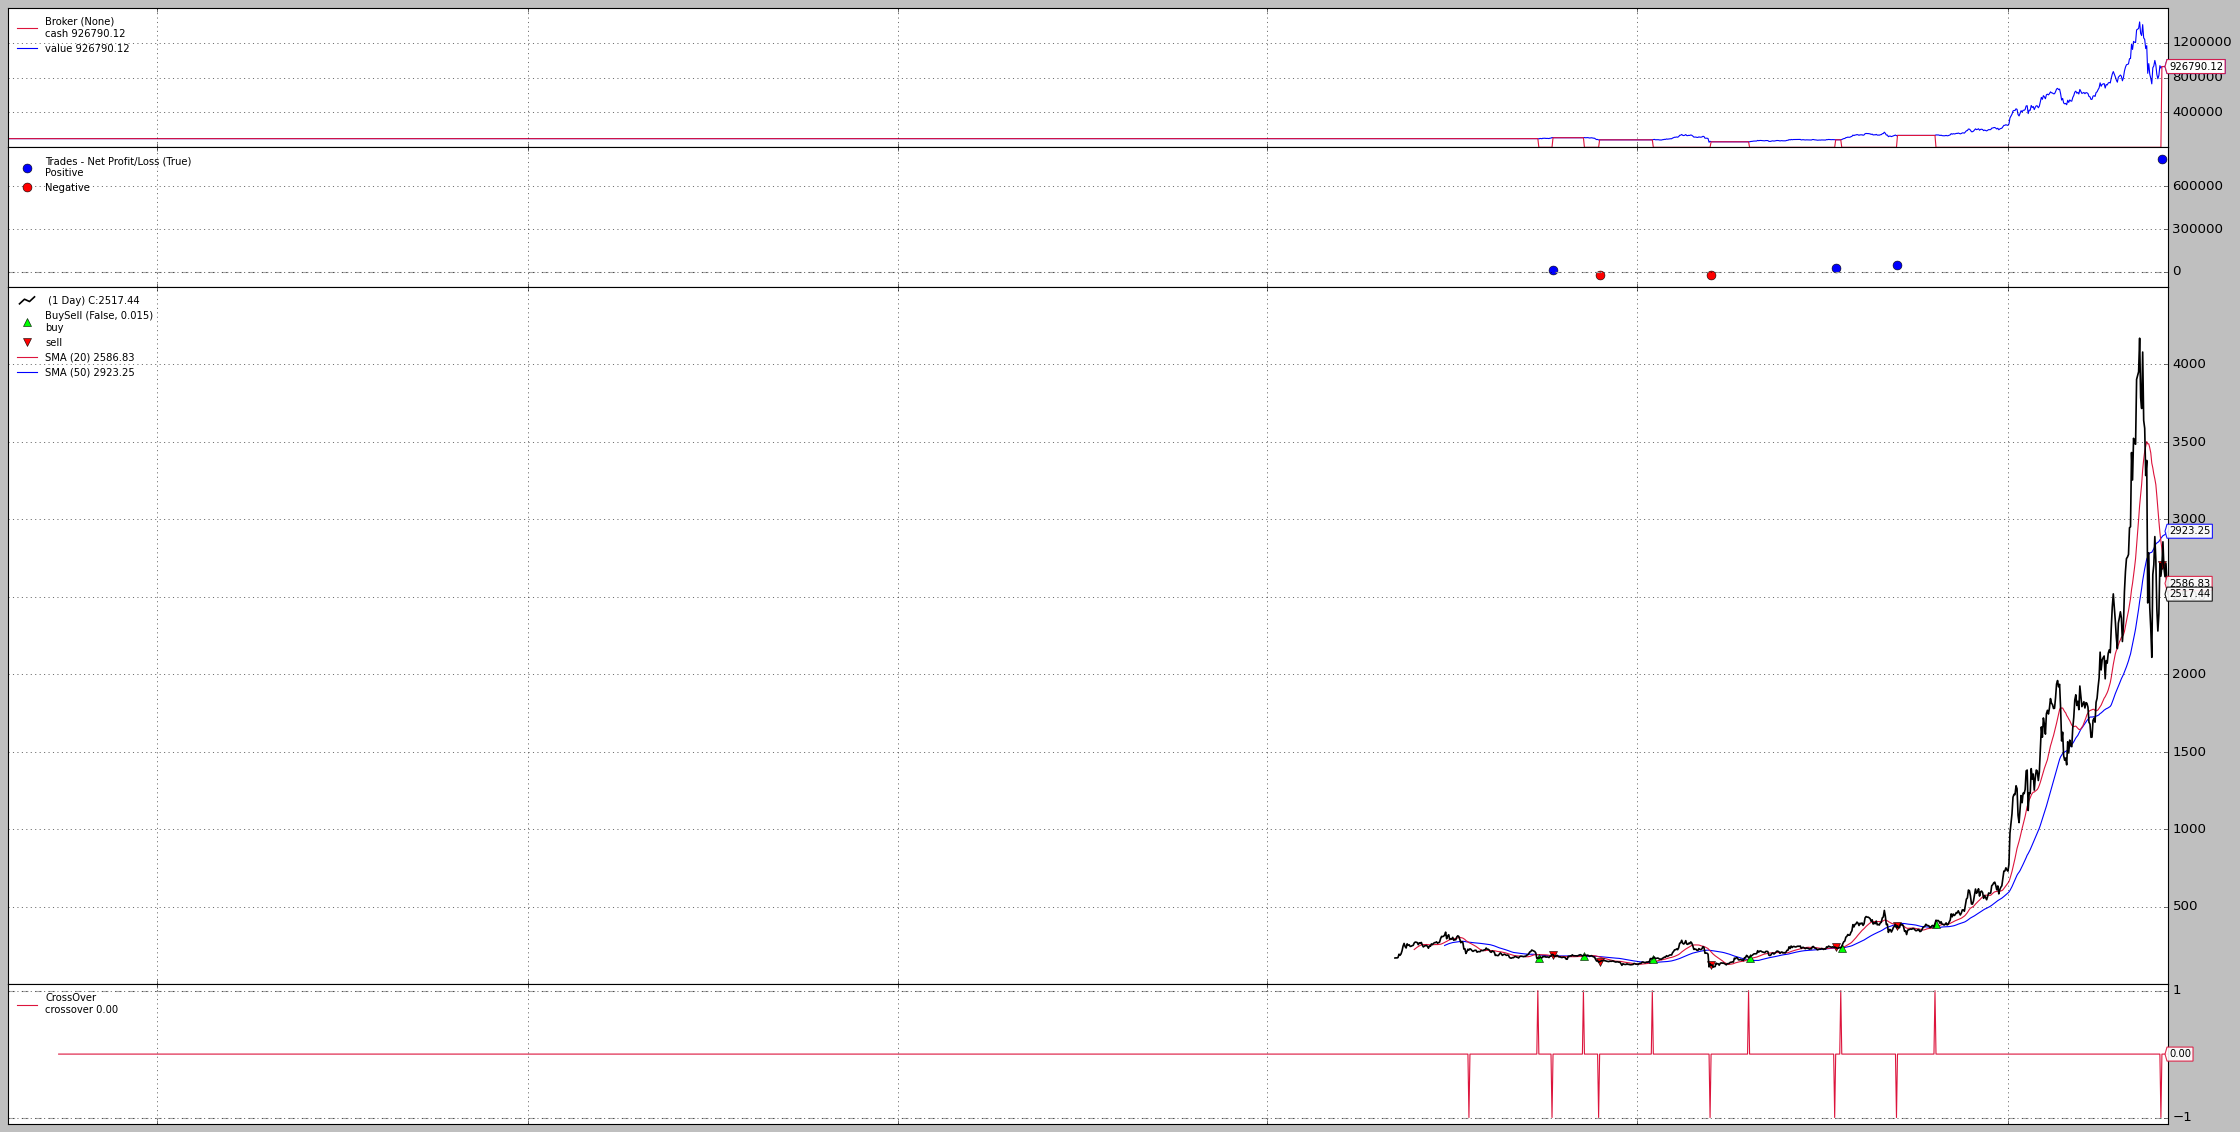

<Figure size 2400x1200 with 0 Axes>

In [ ]:
from fastquant import backtest
eth = pd.DataFrame(df['Close'][1369:], index=df.index)
backtest(strategy='smac', data=eth, fast_period=20, slow_period=50, verbose=0)
# plt.savefig('SMA')

#### Strategy

 The SMA Trading Strategy follows this logic

* When the moving average intersections indicate a buy opportunity, then one unit of Ethereum will be bought.
* When the moving average intersections indicate a sell opportunity, the one unit of Ethereum is sold.

#### Overall performance

    * Final portfolio value of $926,790.12
    * Total profit margin of $828,790.12
    * Multiplied initial investment by 9.268x

### Buy-and-Hold Strategy

#### Strategy
The Buy-and-Hold strategy follows this logic:
* Make an initial investment of \$100,000 and never sell nor buy more.

#### Overall Performance

    * Final Portfolio value of $953,250.79
    * Total profit margin of $853,250.79
    * Multiplied original investment by 9.533x